# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 122.55923438072205 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [7]:
def label_collision_data(df_features, collisions_init):
# Create a binary label column initialized to 0 (no collision)
    df_features['is_collision'] = 0

    # Iterate over each collision interval
    for collision_time in collisions_init:
        mask = (df_features['start'] <= collision_time) & (df_features['end'] >= collision_time)
        
        df_features.loc[mask, 'is_collision'] = 1

    return df_features

In [8]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)

In [9]:
y_test_collision = df_with_labels["is_collision"]


## LSTM-ED

In [10]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=32,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [05:04<00:00,  3.04s/it]


LSTM-ED training completed.


In [11]:
anomaly_scores = None
try:
    anomaly_scores = classifier.predict(X_test)
    # Replace inf values with the maximum float value
    anomaly_scores = np.where(np.isinf(anomaly_scores), np.finfo('float').max, anomaly_scores)
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")
    # If an error occurs, you might want to inspect the model's internal state
print("Anomaly prediction completed.")

Anomaly prediction completed.


In [12]:
threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

In [26]:
median = np.median(anomaly_scores)
mad = np.median(np.abs(anomaly_scores - median))
threshold_2 = median + 3 * mad  

In [14]:
threshold_3 = np.percentile(anomaly_scores, 95)

In [15]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

In [27]:
for threshold in [threshold_1, threshold_2, threshold_3, threshold_4]:
    anomalies_detected = sum(anomaly_scores >= threshold)
    print(f"Number of anomalies detected: {anomalies_detected} with threshold {threshold}")

Number of anomalies detected: 10 with threshold 828.5548218681868
Number of anomalies detected: 115 with threshold 157.30808356718896
Number of anomalies detected: 16 with threshold 754.0236716940869
Number of anomalies detected: 6 with threshold 1050.5309479840184


In [17]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

### Anomaly Detection

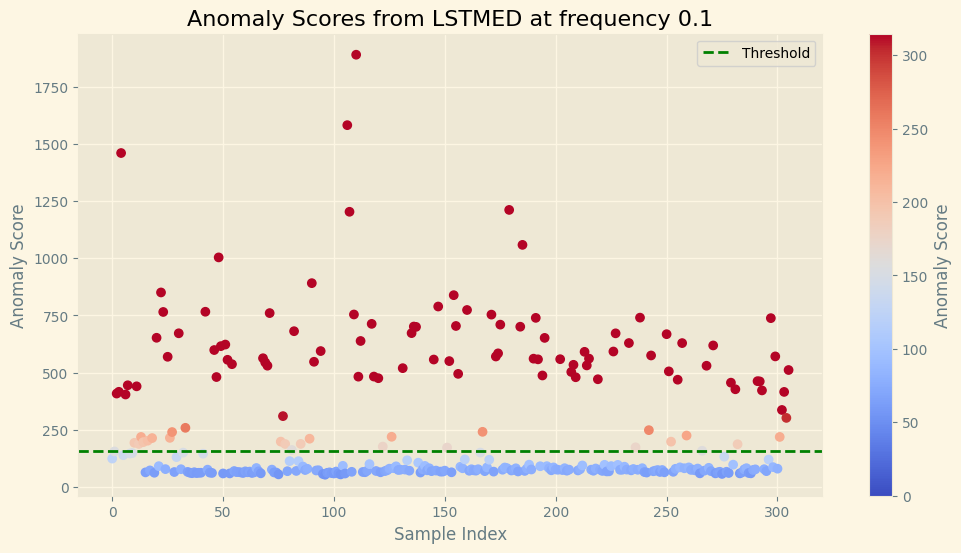

Number of anomalies detected: 115


In [30]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2)

In [42]:
np.count_nonzero(y_test_collision)

105

In [33]:
anomaly_scores, y_test_binary= compute_metrics(anomaly_scores, y_test_collision, threshold_2)

ROC AUC Score: 0.9862
Detected anomaly class: 1
Threshold: 157.3081
F1 Score: 0.9364
Accuracy: 0.9542
Precision: 0.8957
Recall: 0.9810
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       201
           1       0.90      0.98      0.94       105

    accuracy                           0.95       306
   macro avg       0.94      0.96      0.95       306
weighted avg       0.96      0.95      0.95       306



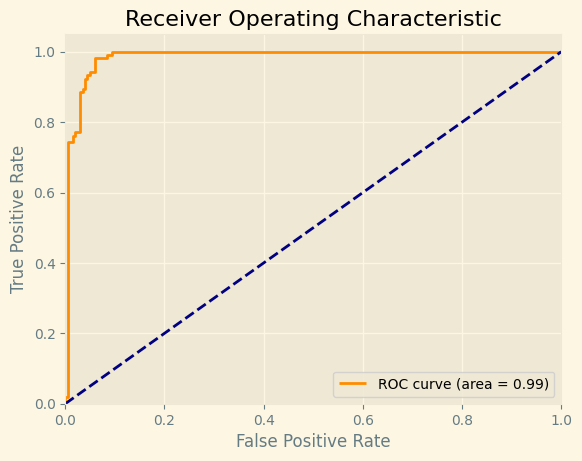

In [34]:
plot_roc_curve(y_test_collision.values, anomaly_scores)

## Map anomalies to original time series

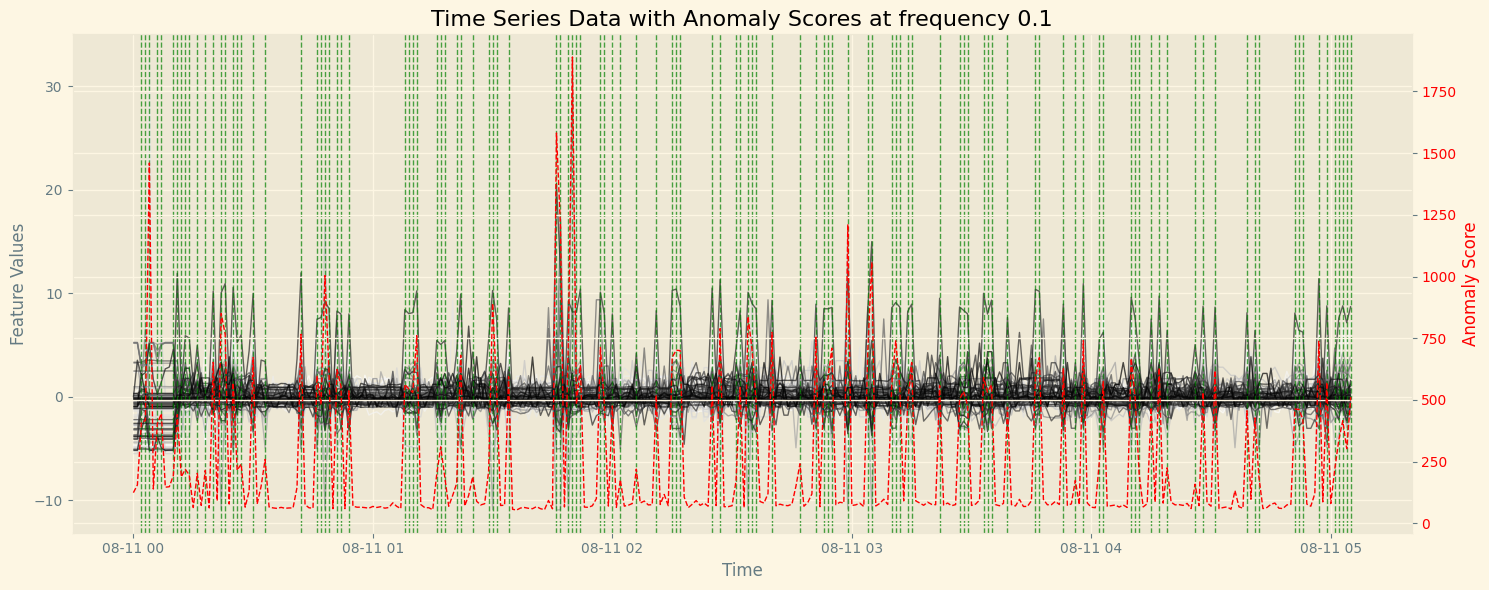

Top 115 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00    1889.373017   
106 2022-08-11 01:46:00    1581.560790   
4   2022-08-11 00:04:00    1459.771014   
179 2022-08-11 02:59:00    1211.168408   
107 2022-08-11 01:47:00    1203.039191   
..                  ...            ...   
122 2022-08-11 02:02:00     176.809670   
236 2022-08-11 03:56:00     173.662572   
151 2022-08-11 02:31:00     172.565780   
81  2022-08-11 01:21:00     162.012267   
266 2022-08-11 04:26:00     158.599214   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
106                                          -1.885449      
4                                            -5.323114      
179                                          -1.338344      
107                                          -1.181816      
..                                                 ...      
122                                           0.0

In [36]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)